**Image Classification Experiment**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#getting the dataset, change to cifar100 if needed

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:22<00:00, 7634537.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


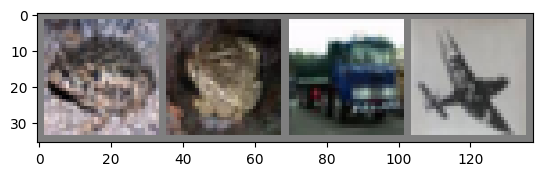

frog  frog  truck plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

LeNet Model: standard Convolution 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

LeNet Model: ACDA

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.acda1 = Conv_DCFD(3, 6, kernel_size=7, padding=1, stride=1, bias=True)#.cuda()
        self.pool = nn.MaxPool2d(2, 2)
        self.acda2 = Conv_DCFD(6, 16, kernel_size=7, padding=1, stride=1, bias=True)#.cuda()
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.acda1(x)))
        x = self.pool(F.relu(self.acda2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        y = self.fc1(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net1()

ResNet Model: ACDA

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 64, 3, stride = 1)
        self.maxpool = nn.MaxPool2d(3,2)

        self.conv11 = nn.Conv2d(64,64,3)
        self.conv12 = nn.Conv2d(64,64,3)

        self.conv21 = nn.Conv2d(64,128,3)
        self.conv22 = nn.Conv2d(128,128,3)
        self.conv23 = nn.Conv2d(128,64,3)
        
        self.conv31 = nn.Conv2d(128,128,1)
        self.acda1 = Conv_DCFD(128, 128, kernel_size=7, inter_kernel_size=7, padding=1, stride=1, bias=True)#.cuda()
        self.conv32 = nn.Conv2d(128,256,1)
        self.conv33 = nn.Conv2d(256,128,1)

        self.conv41 = nn.Conv2d(256,256,1)
        self.acda2 = Conv_DCFD(256, 256, kernel_size=7, inter_kernel_size=7, padding=1, stride=1, bias=True)
        self.conv42 = nn.Conv2d(256,512,1)
        self.conv43 = nn.Conv2d(512,256,1)

        self.avg = nn.AvgPool2d(3)

        self.fc1 = nn.Linear(512* 4 * 4, 1000)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = (F.relu(self.conv0(x))) #layer 0

        x = F.relu(self.conv12(F.relu(self.conv11(x)))) #layer 1
        x = F.relu(self.conv12(F.relu(self.conv11(x))))

        x = F.relu(F.relu(self.conv22(F.relu(self.conv21(x))))) #layer 2
        x = F.relu(self.conv22(F.relu(self.conv22(x))))

        x = F.relu(self.conv32(self.acda1(F.relu(self.conv31(x))))) #layer 3
        x = self.conv32(self.acda1(self.conv33(x)))

        x = F.relu(self.conv42(self.acda2(F.relu(self.conv41(x))))) #layer 4
        x = self.conv42(self.acda2(self.conv43(x)))

        x = self.avg(x) #avg layer

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) #linear layer

        return x


net2 = Net2()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs: [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Streaming output truncated to the last 5000 lines.
final shape torch.Size([4, 512, 4, 4])
6503
final shape torch.Size([4, 512, 4, 4])
6504
final shape torch.Size([4, 512, 4, 4])
6505
final shape torch.Size([4, 512, 4, 4])
6506
final shape torch.Size([4, 512, 4, 4])
6507
final shape torch.Size([4, 512, 4, 4])
6508
final shape torch.Size([4, 512, 4, 4])
6509
final shape torch.Size([4, 512, 4, 4])
6510
final shape torch.Size([4, 512, 4, 4])
6511
final shape torch.Size([4, 512, 4, 4])
6512
final shape torch.Size([4, 512, 4, 4])
6513
final shape torch.Size([4, 512, 4, 4])
6514
final shape torch.Size([4, 512, 4, 4])
6515
final shape torch.Size([4, 512, 4, 4])
6516
final shape torch.Size([4, 512, 4, 4])
6517
final shape torch.Size([4, 512, 4, 4])
6518
final shape torch.Size([4, 512, 4, 4])
6519
final shape torch.Size([4, 512, 4, 4])
6520
final shape torch.Size([4, 512, 4, 4])
6521
final shape torch.Size([4, 512, 4, 4])
6522
final shape torch.Size([4, 512, 4, 4])
6523
final shape torch.Size([4

In [ ]:
#Calculate Accuracy

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net13(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

NameError: ignored

In [ ]:
!pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
The code is directly translated from the matlab code 
https://github.com/xycheng/DCFNet/blob/master/calculate_FB_bases.m
'''
import numpy as np 
from scipy import special
import pdb
from config import *

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (phi, rho)

def calculate_FB_bases(L1):
	maxK = (2 * L1 + 1)**2 - 1

	L = L1 + 1
	R = L1 + 0.5

	truncate_freq_factor = 1.5

	if L1 < 2:
		truncate_freq_factor = 2

	xx, yy = np.meshgrid(range(-L, L+1), range(-L, L+1))

	xx = xx/R
	yy = yy/R

	ugrid = np.concatenate([yy.reshape(-1,1), xx.reshape(-1,1)], 1)
	tgrid, rgrid = cart2pol(ugrid[:,0], ugrid[:,1])

	num_grid_points = ugrid.shape[0]

	kmax = 15

	bessel = np.load('./bessel.npy')

	B = bessel[(bessel[:,0] <=kmax) & (bessel[:,3]<= np.pi*R*truncate_freq_factor)]

	idxB = np.argsort(B[:,2])

	mu_ns = B[idxB, 2]**2

	ang_freqs = B[idxB, 0]
	rad_freqs = B[idxB, 1]
	R_ns = B[idxB, 2]

	num_kq_all = len(ang_freqs)
	max_ang_freqs = max(ang_freqs)

	Phi_ns=np.zeros((num_grid_points, num_kq_all), np.float32)

	Psi = []
	kq_Psi = []
	num_bases=0

	for i in range(B.shape[0]):
		ki = ang_freqs[i]
		qi = rad_freqs[i]
		rkqi = R_ns[i]

		r0grid=rgrid*R_ns[i]

		F = special.jv(ki, r0grid)

		Phi = 1./np.abs(special.jv(ki+1, R_ns[i]))*F

		Phi[rgrid >=1]=0

		Phi_ns[:, i] = Phi

		if ki == 0:
			Psi.append(Phi)
			kq_Psi.append([ki,qi,rkqi])
			num_bases = num_bases+1

		else:
			Psi.append(Phi*np.cos(ki*tgrid)*np.sqrt(2))
			Psi.append(Phi*np.sin(ki*tgrid)*np.sqrt(2))
			kq_Psi.append([ki,qi,rkqi])
			kq_Psi.append([ki,qi,rkqi])
			num_bases = num_bases+2

	Psi = np.array(Psi)
	kq_Psi = np.array(kq_Psi)

	num_bases = Psi.shape[1]

	if num_bases > maxK:
		Psi = Psi[:maxK]
		kq_Psi = kq_Psi[:maxK]
	num_bases = Psi.shape[0]
	p = Psi.reshape(num_bases, 2*L+1, 2*L+1).transpose(1,2,0)
	psi = p[1:-1, 1:-1, :]
	# print(psi.shape)
	psi = psi.reshape((2*L1+1)**2, num_bases)

	c = np.sqrt(np.sum(psi**2, 0).mean())

	psi = psi/c

	return psi, c, kq_Psi


In [ ]:
!pip install fb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fb: filename=fb-0.4.0-py3-none-any.whl size=7159 sha256=ebdc318709953fa29e3a81e6dbb6007830d2e9207815024ac6b41852f7f02ca6
  Stored in directory: /root/.cache/pip/wheels/49/cd/23/e665d689c81d1485aa0d2aac72e7a27bbb28f0b99694c5554b
Successfully built fb


In [ ]:
#--------------------------------------------ACDA LAYER------------------------------

#since I ran the experiments first with the existing acda layer code, 
#and a few variables, like layer name conv_DCDF, were used in all the experiments, 
#I did not change those variables to avoid mistakes within the experiment

#add bessel.npy before running this

#importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils import spectral_norm
from torch.autograd import Variable
from torch.nn.parameter import Parameter

import math
import scipy as sp
import scipy.linalg as linalg
import numpy as np
import pdb
from fb import *
import matplotlib as plt

class Conv_DCFD(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, num_bases=6, 
                 bias=True, dilation=1, groups=1):
      
        super(Conv_DCFD, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.num_bases = num_bases
        self.dilation = dilation
        self.groups = groups

        #creating the bases_list containing 6*(kernel_size//2) (example for kernel size 7x7 the total bases would be 18)

        list_size = kernel_size // 2
        bases_list = []

        for i in range(list_size):
            kss = (i+1)*2+1
            FB_bases, _, _ = calculate_FB_bases(i+1)    #calculating FB bases
            FB_bases = FB_bases.transpose().reshape(-1, kss, kss).astype(np.float32)[:num_bases, ...]
            pad = list_size - (i+1)
            bases1 = torch.Tensor(FB_bases)
            bases1 = F.pad(bases1, (pad, pad, pad, pad, 0, 0)).view(num_bases, kernel_size*kernel_size)
            bases_list.append(bases1)
            
        bases = torch.cat(bases_list,0)
        bases_size = num_bases * len(bases)
        ## bases created

        self.register_buffer('bases', torch.Tensor(bases).float())
        self.tem_size = len(bases)
        
        inter = max(64, bases_size//2)    #channels for convolution
        
        #------NOW DECOMPOSING THE PER_PIXEL ADAPTIVE FILTER INTO DYNAMIC ATOMS AND COMPOSITIONAL COEFFICIENTS-------

        #COMPOSITIONAL COEFFICIENTS

        self.compositional_coef = Parameter(torch.Tensor(out_channels, in_channels*num_bases, 1, 1))  #2d with size c'xcm 


        #CREATING THE ATOM GENERATION NETWORK
        
        #we decompose the dynamic filter into pre-fixed bases and basis coefficients
        # atom_gen outputs the coefficients a, corresponding to all bases

        self.atom_gen = nn.Sequential(
            nn.Conv2d(in_channels, inter, kernel_size=self.kernel_size, padding=1, stride=stride),  #change kernelsize
            nn.BatchNorm2d(inter),
            nn.Tanh(),
            nn.Conv2d(inter, bases_size, kernel_size=3, padding=1),  # keep the kernel_size fixed as 3
            nn.BatchNorm2d(bases_size),
            nn.Tanh()
            )

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)


    def forward(self, input):
        N, C, H, W = input.shape

        H = (H + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1)//self.stride + 1
        W = (W + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1)//self.stride + 1
        M = self.num_bases
        

        drop_rate = 0.0
   
        #LAYER 1
        #get the bases generated using atom generation network
        bases = self.atom_gen(F.dropout2d(input, p=drop_rate, training=self.training)).view(N, self.num_bases, self.tem_size, H, W) # BxMxMxHxW
       
        self.bases_coef = bases.cpu().data.numpy() #basis coefficients

        bases = torch.einsum('bmkhw, kl->bmlhw', bases, self.bases)
        self.bases_save = bases.cpu().data.numpy()

        x = F.unfold(F.dropout2d(input, p=drop_rate, training=self.training), kernel_size=self.kernel_size, stride=self.stride, padding=self.padding).view(N, self.in_channels, self.kernel_size*self.kernel_size, H, W)
        
        #get the intermediate feature Z of size cmxhxw
        intermediate_layer = torch.einsum('bmlhw, bclhw-> bcmhw', bases.view(N, self.num_bases, -1, H, W), x).reshape(N, self.in_channels*self.num_bases, H, W)
        intermediate_layer = F.dropout2d(intermediate_layer, p=drop_rate, training=self.training)

        #change padding for every kernel size to have the output of the same for every kernel_size
        pad = ((self.kernel_size - 3)/2)//self.stride
        pad = int(pad)

        #LAYER 2
        #convolution  of Z with compositional coeff
        output = F.conv2d(intermediate_layer, self.compositional_coef, self.bias,stride=self.stride, padding=pad, dilation=self.dilation, groups=self.groups)

        return output



torch.Size([1, 10, 25, 25])
torch.Size([1, 3, 100, 100])
